In [3]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model


### Cargamos el dataset

In [4]:
df = pd.read_csv('titanic.csv')
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']
df['Age'] = df['Age'].fillna(df.Age.mean())

### Creamos un modelo

In [5]:
target = 'Survived'
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


model = linear_model.LogisticRegression()
model.fit(X_train, y_train)
probabilidades = model.predict_proba(X_test)[:, 1]


### Matriz de confusion

|                     | **Predicho Positivo** | **Predicho Negativo** |
|---------------------|-----------------------|-----------------------|
| **Real Positivo**   | True Positives (TP) | False Negatives (FN) |
| **Real Negativo**   | False Positives (FP) | True Negatives (TN) |


- TP (Verdaderos Positivos): Casos positivos correctamente clasificados.

- FN (Falsos Negativos): Casos positivos incorrectamente clasificados como negativos.

- FP (Falsos Positivos): Casos negativos incorrectamente clasificados como positivos.

- TN (Verdaderos Negativos): Casos negativos correctamente clasificados.

In [6]:
# Crea una matriz de confusión con Sklearn
from sklearn.metrics import confusion_matrix
predicciones = model.predict(X_test)
matriz_confusion = confusion_matrix(y_pred=predicciones, y_true=y_test)



### Sensitivity 

Dentro de los que si sobreviven, que porcentaje predice bien el modelo

$$\text{Sensitivity} = \frac{\text{True positive (TP)}}{\text{True positive (TP)} + \text{False Negative (FN)}}$$

In [7]:
matriz_confusion

array([[143,  25],
       [ 28,  72]], dtype=int64)

In [8]:
TP = matriz_confusion[0][0]

In [9]:
FN = matriz_confusion[0][1]

In [10]:
TP / (TP + FN)

0.8511904761904762

### Especificidad 

De los que no sobreviven, que porcentaje predice bien el modelo 

$$\text{Specificity} = \frac{\text{True Negative (TN)}}{\text{True Negative (TN)} + \text{False Positive (FP)}}$$


In [11]:
TN = matriz_confusion[1][1]
TN

72

In [12]:
FP = matriz_confusion[1][0]
FP

28

In [13]:
TN / (TN + FP)

0.72

### Recrea la matriz de confusión, calcula sensitivity y specificity con un corte de 0.7

In [14]:
predicciones1 = probabilidades > 0.7

matriz_confusion1 = confusion_matrix(y_pred=predicciones1, y_true=y_test)
matriz_confusion1

array([[162,   6],
       [ 50,  50]], dtype=int64)

In [15]:
matriz_confusion

array([[143,  25],
       [ 28,  72]], dtype=int64)

In [16]:
# Sensitivity = TP / (TP + FN)
TP = matriz_confusion1[0][0]
FN = matriz_confusion1[0][1]

TP / (TP + FN)

0.9642857142857143

In [17]:
# Specificity = TN / (TN + FP)
TN = matriz_confusion1[1][1]
FP = matriz_confusion1[1][0]

TN / (TN + FP)

0.5

### Siempre habrá un balance entre sensitivity y specificity en la elección de los cortes 



In [18]:
# Calcular para varios valores 
valores = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
sensitivity = []
specificity = []
for i in valores:
    predicciones = probabilidades > i
    matriz_confusion = confusion_matrix(y_pred=predicciones,
                                        y_true=y_test)
    
    TP = matriz_confusion[0][0]
    FN = matriz_confusion[0][1]

    TN = matriz_confusion[1][1]
    FP = matriz_confusion[1][0]

    sen = TP/(TP+FN)
    spec = TN/(TN+FP)

    sensitivity.append(sen)
    specificity.append(spec)


In [19]:
specificity_minus = [1 - i for i in specificity]

Text(0.5, 1.0, 'ROC curve')

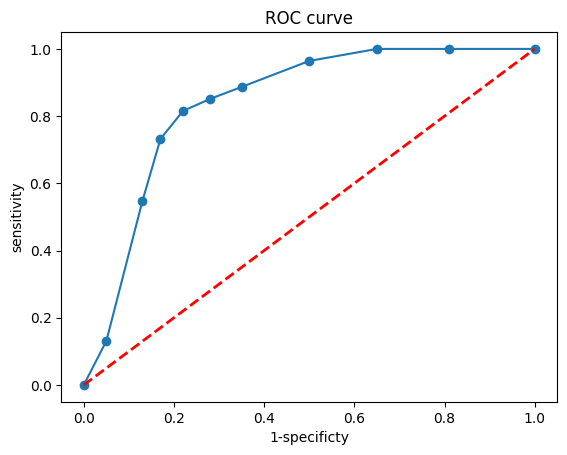

In [20]:
plt.plot(specificity_minus, sensitivity, marker="o")
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.xlabel("1-specificty")
plt.ylabel("sensitivity")
plt.title("ROC curve")

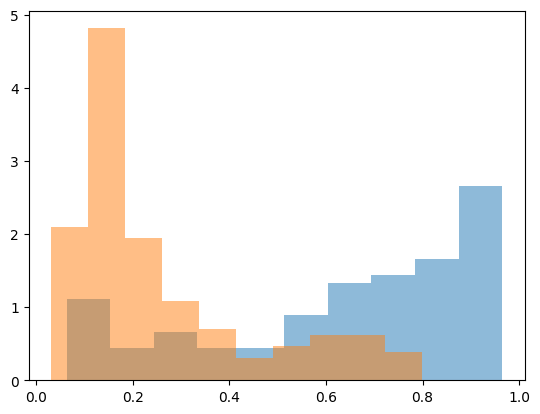

In [21]:
df = pd.DataFrame({
    'y':y_test,
    'probabilidades': probabilidades
})
plt.hist(df.query("y == 1").probabilidades, alpha=0.5, density=True)
plt.hist(df.query("y == 0").probabilidades, alpha=0.5, density=True)
plt.show()

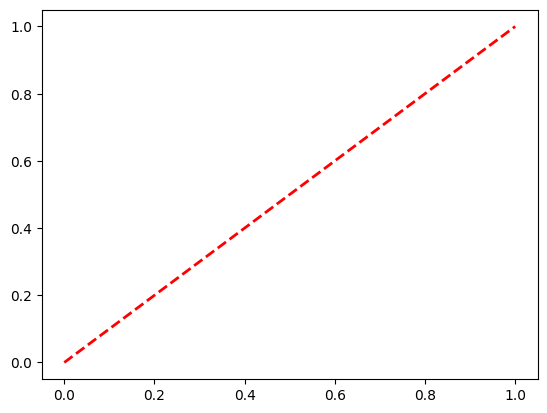

In [22]:
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')

### Utiliza sklearn para obtener esta curva

In [45]:
from sklearn.metrics import roc_curve
fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y_test)

In [46]:
import random
probabilidades1 = [random.random() for _ in range(len(y_test))]
fpr1, fpn1, scores1 = roc_curve(y_score=probabilidades1, y_true=y_test)

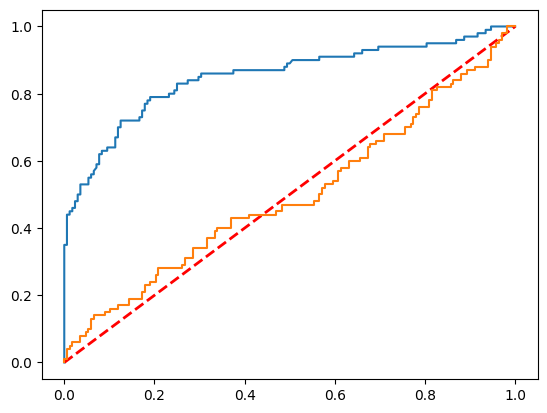

In [47]:
plt.plot(fpr, fpn)
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')
plt.plot(fpr1, fpn1)

### Definición, el AUC es el área del gráfico anterior que está bajo la linea (área bajo la curva)

Si se toman dos datos al azar, uno que sobrevive y otro que no sobrevive, ¿cuál es la probabilidad de que el que sobrevive tenga mayor probabilidad predicha?



In [38]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_score=probabilidades, y_true=y_test)



0.8509523809523809

In [39]:
roc_auc_score(y_score=probabilidades1, y_true=y_test)

0.5060119047619047

In [41]:
# GINI = 2 * AUC - 1
2 * roc_auc_score(y_score=probabilidades, y_true=y_test) - 1

0.7019047619047618

### Calcula el AUC de una regresión polinomial grado 2

In [26]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly_features", PolynomialFeatures(degree=2)),
    ("model", linear_model.LogisticRegression(penalty='l2'))
])

pipeline.fit(X_train, y_train)

probabilidades_modelo2 = pipeline.predict_proba(X_test)[:, 1]

# Calcula el AUC


### Compara las dos ROC curves

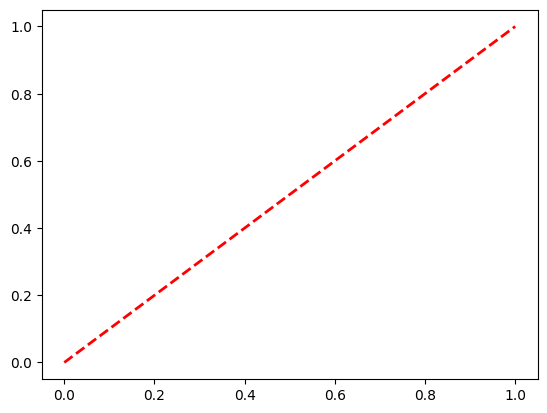

In [27]:
plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Clasificador aleatorio')

### KNN clasificación, cross validation de vecions más cercanos con AUC

In [50]:
from sklearn import neighbors
vecinos = []
auc = []
for i in range(1, 100):
    model = neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train, y_train)
    probabilidades = model.predict_proba(X_test)[:,1]
    vecinos.append(i)
    auc.append(roc_auc_score(y_score=probabilidades, y_true=y_test))

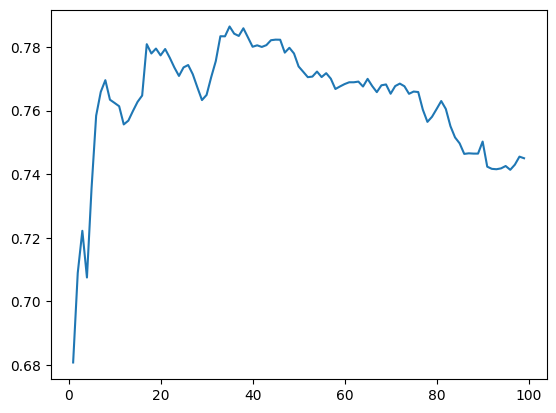

In [51]:
plt.plot(vecinos, auc)